## Plot dataset

In [1]:
from landslide.data import LandslideDataset, dataloader
from pathlib import Path
from matplotlib import pyplot as plt
import torch
import numpy as np


ds = LandslideDataset(Path('../dataset/processed/L4S/test'), do_normalize=False)
bs = 3
print(f"Dataset length: {len(ds)}")
loader = dataloader(ds, batch_size=bs, shuffle=False, mode='valid')

img, mask = next(iter(loader))

print(f"min: {img.min()}, max: {img.max()}")
img = (img * 255).to(dtype=torch.uint8).numpy().transpose((0, 2, 3, 1)) # (B, C, H, W) -> (B, H, W, C)
mask = (mask * 255).to(dtype=torch.uint8).numpy().transpose((0, 2, 3, 1)) # (B, C, H, W) -> (B, H, W, C)

fig, axes = plt.subplots(2, bs, figsize=(15, 8))

# Plot images and masks
for j in range(bs):
    if j < img.shape[0]:  # Check if we have enough images
        # Plot image
        axes[0, j].imshow(img[j])
        axes[0, j].axis('off')
        axes[0, j].set_title(f'Image {j+1}')
    
        # Plot mask
        axes[1, j].imshow(mask[j], cmap='gray')
        axes[1, j].axis('off')
        axes[1, j].set_title(f'Mask {j+1}')

plt.tight_layout()
plt.show()


/Users/gianlucacalo/anaconda3/envs/ml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset length: 1600


AttributeError: Caught AttributeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/Users/gianlucacalo/anaconda3/envs/ml/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
           ^^^^^^^^^^^^^^^^^^^^
  File "/Users/gianlucacalo/anaconda3/envs/ml/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/gianlucacalo/anaconda3/envs/ml/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/Users/gianlucacalo/Desktop/projects/landslide/landslide/data.py", line 140, in __getitem__
    return self.preprocess_img(img), self.preprocess_mask(mask)
           ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/gianlucacalo/Desktop/projects/landslide/landslide/data.py", line 127, in preprocess_img
    do_resize=self.do_resize,
              ^^^^^^^^^^^^^^
AttributeError: 'LandslideDataset' object has no attribute 'do_resize'


## Model forward

In [5]:
from landslide.model import UNet
import torch

model = UNet(nc=1, ch=3)

im = torch.randn(2, 3, 128, 128)
out = model(im)
print(out.shape)

# get the number of parameters,flops

torch.Size([2, 1, 128, 128])


## Compute statistics

In [ ]:
from landslide.data import LandslideDataset, dataloader
from pathlib import Path
import torch
import numpy as np
from matplotlib import pyplot as plt
# Define dataset and dataloader (adjust the path and parameters as needed)
ds = LandslideDataset(Path('../dataset/processed/A19/img'), do_normalize=False)
print(f"Dataset length: {len(ds)}")
loader = dataloader(ds, batch_size=32, workers=0, shuffle=False, mode='valid')


# Initialize variables to store running statistics
pixel_sum = torch.zeros(3)  # For RGB channels
pixel_squared_sum = torch.zeros(3)
pixel_count = 0
pos_count = 0  # Count of positive (landslide) pixels
neg_count = 0  # Count of negative (non-landslide) pixels
num_patches_with_landslide = 0

# Iterate through the dataloader
for images, masks in loader:
    B, C, H, W = images.shape

    # Sum up all pixel values and their squares for each channel
    pixel_sum += images.sum(dim=[0, 2, 3])  # Sum across batch, height, and width
    pixel_squared_sum += (images ** 2).sum(dim=[0, 2, 3])
    
    # Count total number of pixels
    batch_pixels = images.size(0) * images.size(2) * images.size(3)
    pixel_count += batch_pixels

    masks = masks.to(dtype=torch.bool)
    pc = (masks == 1).sum().item()
    num_patches_with_landslide += 1 if pc > 0 else 0
    pos_count += pc
    neg_count += (masks == 0).sum().item()


# Calculate mean
mean = pixel_sum / pixel_count

# Calculate standard deviation
# std = sqrt(E[X^2] - (E[X])^2)
variance = (pixel_squared_sum / pixel_count) - (mean ** 2)
std = torch.sqrt(variance)
pos_weight = torch.tensor([neg_count / pos_count])
print("pos_weight:", pos_weight)
print(f"Mean: {mean}")
print(f"Standard deviation: {std}")
print(f"Number of patches with landslides: {num_patches_with_landslide}/{len(ds)}")

Dataset length: 638
pos_weight: tensor([97.7641])
Mean: tensor([0.2875, 0.3134, 0.2851])
Standard deviation: tensor([0.1067, 0.1083, 0.1036])
Number of patches with landslides: 5/638


: 

In [13]:
import torch
target = torch.ones([1, 10], dtype=torch.float32)  # 64 classes, batch size = 10
output = torch.full([1, 10], 1.5)  # A prediction (logit)
pos_weight = None
# pos_weight = torch.ones([1, 1])  # All weights are equal to 1
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight, reduction='none')
loss = criterion(output, target)  # -log(sigmoid(1.5))
torch.exp(-loss)



tensor([[0.8176, 0.8176, 0.8176, 0.8176, 0.8176, 0.8176, 0.8176, 0.8176, 0.8176,
         0.8176]])

In [20]:
! pip install safetensors

In [2]:
from safetensors import safe_open
from landslide.model.segformer import SegformerForSemanticSegmentation, SegformerConfig


config = SegformerConfig()
config.num_labels = 150

model = SegformerForSemanticSegmentation(config)

tensors = {}

model_keys = model.state_dict().keys()
# Load the weights from safetensor file
with safe_open("../models/segformer-b0-finetuned-ade-512-512/model.safetensors", framework="pt", device="cpu") as f:
    # Get all available keys from the safetensor file
    keys = f.keys()

    # Load each tensor into the dictionary
    for k in keys:
        tensors[k] = f.get_tensor(k)


# Load the state dict into the model
model.load_state_dict(tensors, strict=True)


<All keys matched successfully>

In [ ]:
from PIL import Image
import requests
from landslide.data import preprocess
from matplotlib import pyplot as plt

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

plt.imshow(image)
plt.show()


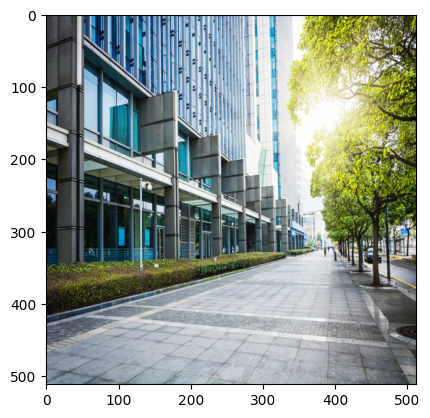

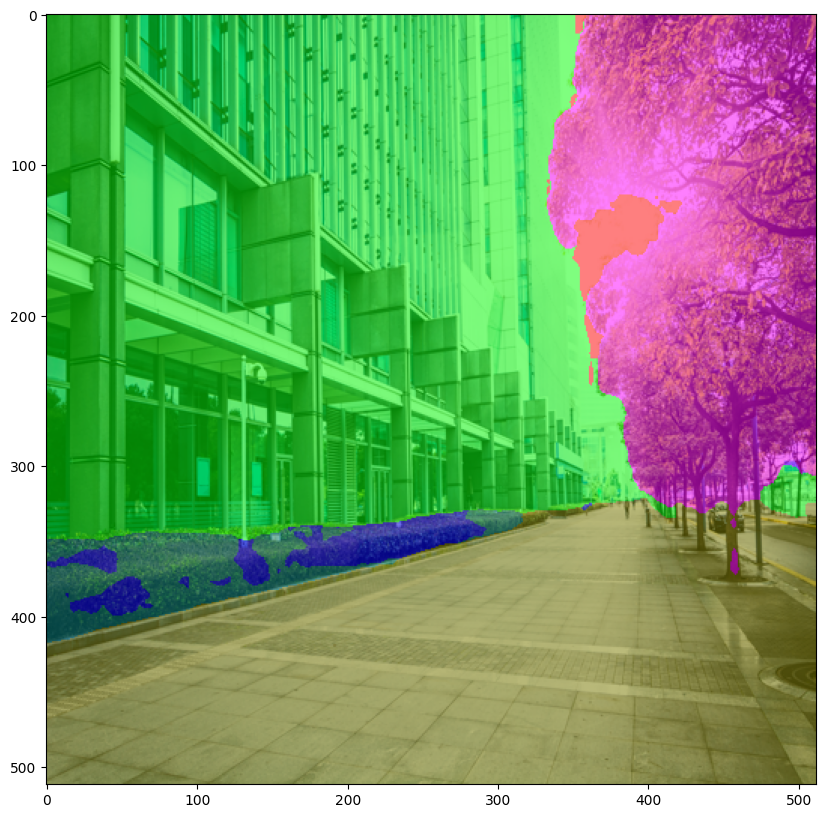

In [ ]:
import matplotlib.pyplot as plt
import torch.nn as nn
from PIL import Image
import requests
from landslide.data import preprocess
from matplotlib import pyplot as plt
import torch
import numpy as np
from safetensors import safe_open
from landslide.model.segformer import SegformerForSemanticSegmentation, SegformerConfig


config = SegformerConfig()
config.num_labels = 150

model = SegformerForSemanticSegmentation(config)

tensors = {}

model_keys = model.state_dict().keys()
# Load the weights from safetensor file
with safe_open("../models/segformer-b0-finetuned-ade-512-512/model.safetensors", framework="pt", device="cpu") as f:
    # Get all available keys from the safetensor file
    keys = f.keys()

    # Load each tensor into the dictionary
    for k in keys:
        tensors[k] = f.get_tensor(k)


# Load the state dict into the model
model.load_state_dict(tensors, strict=True)

url = "https://leeruben-rae-2.hf.space/file=/home/user/app/c-1.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image = image.resize((512, 512))
image = np.array(image)

plt.imshow(image)
plt.show()

x = preprocess(image, size=(512, 512), do_normalize=True)
x = x.unsqueeze(0)

model.eval()

with torch.inference_mode():
    logits = model(x)


def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [
        [255, 0, 0],
        [0, 255, 0],
        [0, 0, 255],
        [255, 255, 0],
        [255, 0, 255],
        [0, 255, 255],
        [128, 0, 0],
        [0, 128, 0],
        [0, 0, 128],
        [128, 128, 0],
        [128, 0, 128],
        [0, 128, 128],
        [192, 192, 192],
        [128, 128, 128],
        [255, 128, 0],
        [128, 255, 0],
        [128, 0, 255],
        [255, 0, 0],
        [0, 255, 0],
        [0, 0, 255],
        [255, 255, 0],
        [255, 0, 255],
        [0, 255, 255],
        [128, 0, 0],
        [0, 128, 0],
        [0, 0, 128],
        [128, 128, 0],
        [128, 0, 128],
        [0, 128, 128],
        [192, 192, 192],
        [128, 128, 128],
        [255, 128, 0],
        [128, 255, 0],
        [128, 0, 255],
        [255, 0, 0],
        [0, 255, 0],
        [0, 0, 255],
        [255, 255, 0],
        [255, 0, 255],
        [0, 255, 255],
        [128, 0, 0],
        [0, 128, 0],
        [0, 0, 128],
        [128, 128, 0],
        [128, 0, 128],
        [0, 128, 128],
        [192, 192, 192],
        [128, 128, 128],
        [255, 128, 0],
        [128, 255, 0],
        [128, 0, 255],
        [45, 78, 123],
        [156, 200, 56],
        [32, 90, 210],
        [56, 123, 67],
        [180, 56, 123],
        [123, 67, 45],
        [45, 134, 200],
        [67, 56, 123],
        [78, 123, 67],
        [32, 210, 90],
        [45, 56, 189],
        [123, 56, 123],
        [56, 156, 200],
        [189, 56, 45],
        [112, 200, 56],
        [56, 123, 45],
        [200, 32, 90],
        [123, 45, 78],
        [200, 156, 56],
        [45, 67, 123],
        [56, 45, 78],
        [45, 56, 123],
        [123, 67, 56],
        [56, 78, 123],
        [210, 90, 32],
        [123, 56, 189],
        [45, 200, 134],
        [67, 123, 56],
        [123, 45, 67],
        [90, 32, 210],
        [200, 45, 78],
        [32, 210, 90],
        [45, 123, 67],
        [165, 42, 87],
        [72, 145, 167],
        [15, 158, 75],
        [209, 89, 40],
        [32, 21, 121],
        [184, 20, 100],
        [56, 135, 15],
        [128, 92, 176],
        [1, 119, 140],
        [220, 151, 43],
        [41, 97, 72],
        [148, 38, 27],
        [107, 86, 176],
        [21, 26, 136],
        [174, 27, 90],
        [91, 96, 204],
        [108, 50, 107],
        [27, 45, 136],
        [168, 200, 52],
        [7, 102, 27],
        [42, 93, 56],
        [140, 52, 112],
        [92, 107, 168],
        [17, 118, 176],
        [59, 50, 174],
        [206, 40, 143],
        [44, 19, 142],
        [23, 168, 75],
        [54, 57, 189],
        [144, 21, 15],
        [15, 176, 35],
        [107, 19, 79],
        [204, 52, 114],
        [48, 173, 83],
        [11, 120, 53],
        [206, 104, 28],
        [20, 31, 153],
        [27, 21, 93],
        [11, 206, 138],
        [112, 30, 83],
        [68, 91, 152],
        [153, 13, 43],
        [25, 114, 54],
        [92, 27, 150],
        [108, 42, 59],
        [194, 77, 5],
        [145, 48, 83],
        [7, 113, 19],
        [25, 92, 113],
        [60, 168, 79],
        [78, 33, 120],
        [89, 176, 205],
        [27, 200, 94],
        [210, 67, 23],
        [123, 89, 189],
        [225, 56, 112],
        [75, 156, 45],
        [172, 104, 200],
        [15, 170, 197],
        [240, 133, 65],
        [89, 156, 112],
        [214, 88, 57],
        [156, 134, 200],
        [78, 57, 189],
        [200, 78, 123],
        [106, 120, 210],
        [145, 56, 112],
        [89, 120, 189],
        [185, 206, 56],
        [47, 99, 28],
        [112, 189, 78],
        [200, 112, 89],
        [89, 145, 112],
        [78, 106, 189],
        [112, 78, 189],
        [156, 112, 78],
        [28, 210, 99],
        [78, 89, 189],
        [189, 78, 57],
        [112, 200, 78],
        [189, 47, 78],
        [205, 112, 57],
        [78, 145, 57],
        [200, 78, 112],
        [99, 89, 145],
        [200, 156, 78],
        [57, 78, 145],
        [78, 57, 99],
        [57, 78, 145],
        [145, 112, 78],
        [78, 89, 145],
        [210, 99, 28],
        [145, 78, 189],
        [57, 200, 136],
        [89, 156, 78],
        [145, 78, 99],
        [99, 28, 210],
        [189, 78, 47],
        [28, 210, 99],
        [78, 145, 57],
    ]


upsampled_logits = nn.functional.interpolate(
    logits,
    size=(512, 512),
    mode="bilinear",
    align_corners=False,
)

pred_seg = upsampled_logits.argmax(dim=1)[0]


color_seg = np.zeros((pred_seg.shape[0], pred_seg.shape[1], 3), dtype=np.uint8)
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[pred_seg == label, :] = color
color_seg = color_seg[..., ::-1]  # convert to BGR

img = np.array(image) * 0.5 + color_seg * 0.5  # plot the image with the segmentation map
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()


# https://huggingface.co/docs/transformers/v4.24.0/en/tasks/semantic_segmentation
# https://github.com/huggingface/transformers/tree/main/examples/pytorch/semantic-segmentation

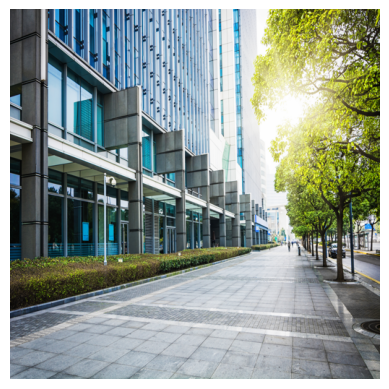

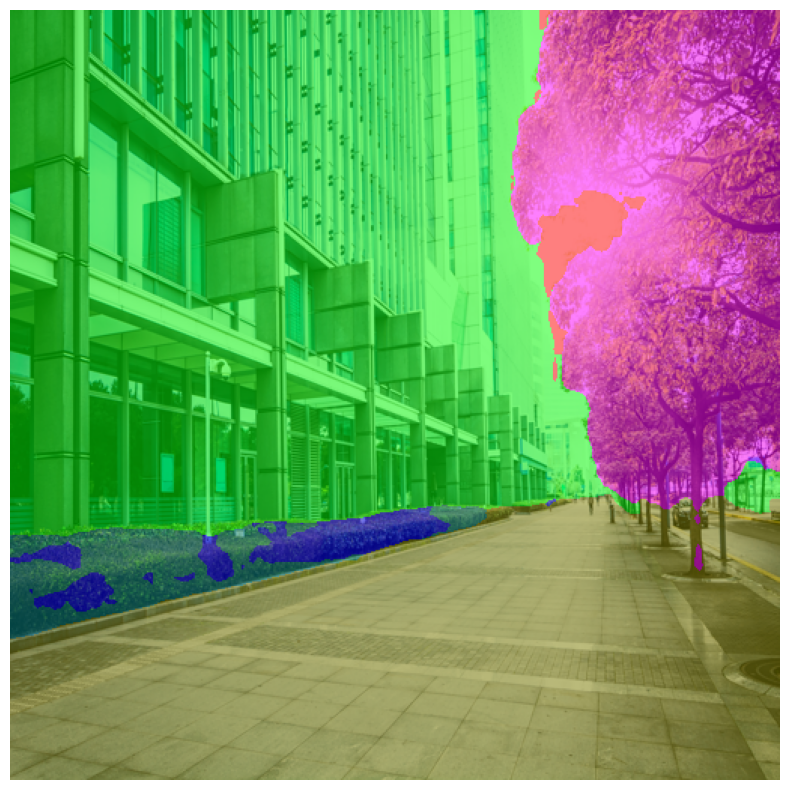

In [6]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from PIL import Image
import requests

from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor

# Specify the model name
model_name = "nvidia/segformer-b0-finetuned-ade-512-512"

# Load the pretrained model and feature extractor
model = SegformerForSemanticSegmentation.from_pretrained(model_name)
feature_extractor = SegformerFeatureExtractor.from_pretrained(model_name)

# Download and open the image
url = "https://leeruben-rae-2.hf.space/file=/home/user/app/c-1.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image = image.resize((512, 512))

plt.imshow(image)
plt.axis("off")
plt.show()

# Preprocess the image using the feature extractor
inputs = feature_extractor(images=image, return_tensors="pt")
model.eval()

# Forward pass with inference mode
with torch.inference_mode():
    outputs = model(**inputs)

logits = outputs.logits

# Upsample the logits to the size of the original image
upsampled_logits = torch.nn.functional.interpolate(
    logits,
    size=(512, 512),
    mode="bilinear",
    align_corners=False,
)
pred_seg = upsampled_logits.argmax(dim=1)[0]

def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [
        [255, 0, 0],
        [0, 255, 0],
        [0, 0, 255],
        [255, 255, 0],
        [255, 0, 255],
        [0, 255, 255],
        [128, 0, 0],
        [0, 128, 0],
        [0, 0, 128],
        [128, 128, 0],
        [128, 0, 128],
        [0, 128, 128],
        [192, 192, 192],
        [128, 128, 128],
        [255, 128, 0],
        [128, 255, 0],
        [128, 0, 255],
        [255, 0, 0],
        [0, 255, 0],
        [0, 0, 255],
        [255, 255, 0],
        [255, 0, 255],
        [0, 255, 255],
        [128, 0, 0],
        [0, 128, 0],
        [0, 0, 128],
        [128, 128, 0],
        [128, 0, 128],
        [0, 128, 128],
        [192, 192, 192],
        [128, 128, 128],
        [255, 128, 0],
        [128, 255, 0],
        [128, 0, 255],
        [255, 0, 0],
        [0, 255, 0],
        [0, 0, 255],
        [255, 255, 0],
        [255, 0, 255],
        [0, 255, 255],
        [128, 0, 0],
        [0, 128, 0],
        [0, 0, 128],
        [128, 128, 0],
        [128, 0, 128],
        [0, 128, 128],
        [192, 192, 192],
        [128, 128, 128],
        [255, 128, 0],
        [128, 255, 0],
        [128, 0, 255],
        [45, 78, 123],
        [156, 200, 56],
        [32, 90, 210],
        [56, 123, 67],
        [180, 56, 123],
        [123, 67, 45],
        [45, 134, 200],
        [67, 56, 123],
        [78, 123, 67],
        [32, 210, 90],
        [45, 56, 189],
        [123, 56, 123],
        [56, 156, 200],
        [189, 56, 45],
        [112, 200, 56],
        [56, 123, 45],
        [200, 32, 90],
        [123, 45, 78],
        [200, 156, 56],
        [45, 67, 123],
        [56, 45, 78],
        [45, 56, 123],
        [123, 67, 56],
        [56, 78, 123],
        [210, 90, 32],
        [123, 56, 189],
        [45, 200, 134],
        [67, 123, 56],
        [123, 45, 67],
        [90, 32, 210],
        [200, 45, 78],
        [32, 210, 90],
        [45, 123, 67],
        [165, 42, 87],
        [72, 145, 167],
        [15, 158, 75],
        [209, 89, 40],
        [32, 21, 121],
        [184, 20, 100],
        [56, 135, 15],
        [128, 92, 176],
        [1, 119, 140],
        [220, 151, 43],
        [41, 97, 72],
        [148, 38, 27],
        [107, 86, 176],
        [21, 26, 136],
        [174, 27, 90],
        [91, 96, 204],
        [108, 50, 107],
        [27, 45, 136],
        [168, 200, 52],
        [7, 102, 27],
        [42, 93, 56],
        [140, 52, 112],
        [92, 107, 168],
        [17, 118, 176],
        [59, 50, 174],
        [206, 40, 143],
        [44, 19, 142],
        [23, 168, 75],
        [54, 57, 189],
        [144, 21, 15],
        [15, 176, 35],
        [107, 19, 79],
        [204, 52, 114],
        [48, 173, 83],
        [11, 120, 53],
        [206, 104, 28],
        [20, 31, 153],
        [27, 21, 93],
        [11, 206, 138],
        [112, 30, 83],
        [68, 91, 152],
        [153, 13, 43],
        [25, 114, 54],
        [92, 27, 150],
        [108, 42, 59],
        [194, 77, 5],
        [145, 48, 83],
        [7, 113, 19],
        [25, 92, 113],
        [60, 168, 79],
        [78, 33, 120],
        [89, 176, 205],
        [27, 200, 94],
        [210, 67, 23],
        [123, 89, 189],
        [225, 56, 112],
        [75, 156, 45],
        [172, 104, 200],
        [15, 170, 197],
        [240, 133, 65],
        [89, 156, 112],
        [214, 88, 57],
        [156, 134, 200],
        [78, 57, 189],
        [200, 78, 123],
        [106, 120, 210],
        [145, 56, 112],
        [89, 120, 189],
        [185, 206, 56],
        [47, 99, 28],
        [112, 189, 78],
        [200, 112, 89],
        [89, 145, 112],
        [78, 106, 189],
        [112, 78, 189],
        [156, 112, 78],
        [28, 210, 99],
        [78, 89, 189],
        [189, 78, 57],
        [112, 200, 78],
        [189, 47, 78],
        [205, 112, 57],
        [78, 145, 57],
        [200, 78, 112],
        [99, 89, 145],
        [200, 156, 78],
        [57, 78, 145],
        [78, 57, 99],
        [57, 78, 145],
        [145, 112, 78],
        [78, 89, 145],
        [210, 99, 28],
        [145, 78, 189],
        [57, 200, 136],
        [89, 156, 78],
        [145, 78, 99],
        [99, 28, 210],
        [189, 78, 47],
        [28, 210, 99],
        [78, 145, 57],
    ]

# Map each predicted label to its corresponding color
color_seg = np.zeros((pred_seg.shape[0], pred_seg.shape[1], 3), dtype=np.uint8)
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[pred_seg == label, :] = color

# Convert color from RGB to BGR if needed (for OpenCV compatibility, for example)
color_seg = color_seg[..., ::-1]

# Blend the original image with the segmentation map
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.axis("off")
plt.show()
